# NLP models

### Download and familiaryze with the dataset.

Source: https://www.kaggle.com/datasets/edenbd/150k-lyrics-labeled-with-spotify-valence

In [2]:
#Data manipulation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Cleaning Lyrics 
import string
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize 

#Summarize Lyrics spaCy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from heapq import nlargest

#Summarize Lyrics NLTK
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import numpy as np
import networkx as nx

#Train LDA model 
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
df = pd.read_csv('../raw_data/labeled_lyrics_cleaned.csv', nrows=2000)
df = df[['artist', 'seq', 'song', 'label']]
df.head()

,artist,seq,song,label
0,Elijah Blake,"No, no\r\nI ain't ever trapped out the bando\r...",Everyday,0.626
1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die,0.630
2,Elijah Blake,She don't live on planet Earth no more\r\nShe ...,The Otherside,0.240
3,Elijah Blake,"Trippin' off that Grigio, mobbin', lights low\...",Pinot,0.536
4,Elijah Blake,"I see a midnight panther, so gallant and so br...",Shadows & Diamonds,0.371


In [4]:
df.shape

(2000, 4)

### Cleaning the data

In [5]:
#Cleans lyrics data by removing special characters
def clean(text):
    ignore = ',.:;?!\''
    music_parts = ['Intro','Outro','Pre-Chorus 1','Verse 1','Verse 1','Verse 1','Verse 1','Verse','Chorous',]
    for char in string.punctuation:
        if char not in ignore:
            text = text.replace(char, ' ') # Remove Punctuation
    for word in music_parts:
        text.replace(word, '')
    text = re.sub(r'\r\n', '. ', text)
    text = re.sub(r'\n', '. ', text)
    return text

#Lematizes the text
def lemmatize(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('english')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma=WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return lemmatized

In [6]:
df['clean_lyrics'] = df.seq.apply(clean)
df['clean_lyrics'] = df['clean_lyrics'].astype('str')
df['lemmatized'] = df.seq.apply(lemmatize)
df['lemmatized'] = df['lemmatized'].astype('str')

df.head()

,artist,seq,song,label,clean_lyrics,lemmatized
0,Elijah Blake,"No, no\r\nI ain't ever trapped out the bando\r...",Everyday,0.626,"No, no. I ain't ever trapped out the bando. Bu...","['ever', 'trapped', 'bando', 'oh', 'lord', 'ge..."
1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die,0.630,"The drinks go down and smoke goes up, I feel m...","['drink', 'go', 'smoke', 'go', 'feel', 'got', ..."
2,Elijah Blake,She don't live on planet Earth no more\r\nShe ...,The Otherside,0.240,She don't live on planet Earth no more. She fo...,"['live', 'planet', 'earth', 'found', 'love', '..."
3,Elijah Blake,"Trippin' off that Grigio, mobbin', lights low\...",Pinot,0.536,"Trippin' off that Grigio, mobbin', lights low....","['trippin', 'grigio', 'mobbin', 'light', 'low'..."
4,Elijah Blake,"I see a midnight panther, so gallant and so br...",Shadows & Diamonds,0.371,"I see a midnight panther, so gallant and so br...","['see', 'midnight', 'panther', 'gallant', 'bra..."


### Create a summary of the clean lyrics

#### spaCy approach

In [7]:
def summarize(text, per):
    nlp = spacy.load('en_core_web_sm')
    doc= nlp(text)
    word_frequencies={}
    for word in doc:
        if word.text.lower() not in list(STOP_WORDS):
            if word.text.lower() not in punctuation:
                if word.text not in word_frequencies.keys():
                    word_frequencies[word.text] = 1
                else:
                    word_frequencies[word.text] += 1
    max_frequency=max(word_frequencies.values())
    for word in word_frequencies.keys():
        word_frequencies[word]=word_frequencies[word]/max_frequency
    sentence_tokens= [sent for sent in doc.sents]
    sentence_scores = {}
    for sent in sentence_tokens:
        for word in sent:
            if word.text.lower() in word_frequencies.keys():
                if sent not in sentence_scores.keys():                            
                    sentence_scores[sent]=word_frequencies[word.text.lower()]
                else:
                    sentence_scores[sent]+=word_frequencies[word.text.lower()]
    select_length=int(len(sentence_tokens)*per)
    summary=nlargest(select_length, sentence_scores,key=sentence_scores.get)
    final_summary=[word.text for word in summary]
    summary=''.join(final_summary)
    return summary

#### NLTK approach

In [8]:
def read_text(text):
    filedata = text
    article = filedata.split(". ")
    sentences = []

    for sentence in article:
        sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
    sentences.pop() 
    
    return sentences

def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)
 
def build_similarity_matrix(sentences, stop_words):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

    return similarity_matrix


def generate_summary(text, top_n=1):
    stop_words = stopwords.words('english')
    summarize_text = []

    #Read text and split it
    sentences =  read_text(text)

    #Generate Similary Martix across sentences
    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)

    #Rank sentences in similarity martix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank(sentence_similarity_graph, tol=1.0e-3)

    #Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)       

    for i in range(top_n):
      summarize_text.append(" ".join(ranked_sentence[i][1]))

    return ". ".join(summarize_text)

#### Comparison between both approaches

In [27]:
text = '''Do you remember
The 21st night of September?
Love was changin' the minds of pretenders
While chasin' the clouds away
Our hearts were ringin'
In the key that our souls were singin'
As we danced in the night, remember
How the stars stole the night away, oh, yeah
Hey, hey, hey
Ba-dee-ya, say, do you remember?
Ba-dee-ya, dancin' in September
Ba-dee-ya, never was a cloudy day
Ba-du-da, ba-du-da, ba-du-da, ba-du
Ba-du-da, ba-du, ba-du-da, ba-du
Ba-du-da, ba-du, ba-du-da
My thoughts are with you
Holdin' hands with your heart to see you
Only blue talk and love, remember
How we knew love was here to stay
Now December
Found the love that we shared in September
Only blue talk and love, remember
The true love we share today
Hey, hey, hey
Ba-dee-ya, say, do you remember?
Ba-dee-ya, dancin' in September
Ba-dee-ya, never was a cloudy day
There was a
Ba-dee-ya (dee-ya, dee-ya), say, do you remember?
Ba-dee-ya (dee-ya, dee-ya), dancin' in September
Ba-dee-ya (dee-ya, dee-ya), golden dreams were shiny days
The bell was ringin', oh, oh
Our souls were singin'
Do you remember never a cloudy day? Yow
There was a
Ba-dee-ya (dee-ya, dee-ya), say, do you remember?
Ba-dee-ya (dee-ya, dee-ya), dancin' in September
Ba-dee-ya (dee-ya, dee-ya), never was a cloudy day
And we'll say
Ba-dee-ya (dee-ya, dee-ya), say, do you remember?
Ba-dee-ya (dee-ya, dee-ya), dancin' in September
Ba-dee-ya (dee ya, dee-ya), golden dreams were shiny days
Ba-dee-ya, dee-ya, dee-ya
Ba-dee-ya, dee-ya, dee-ya
Ba-dee-ya, dee-ya, dee-ya, dee-ya!
Ba-dee-ya, dee-ya, dee-ya
Ba-dee-ya, dee-ya, dee-ya
Ba-dee-ya, dee-ya, dee-ya, dee-ya!
'''

clean_text = clean(text)

In [28]:
summarize(clean_text, 0.05)

'Ba dee ya, dee ya, dee ya, dee ya!.Ba dee ya, dee ya, dee ya, dee ya!.'

In [29]:
generate_summary(clean_text)

PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

### Visualization of words in text

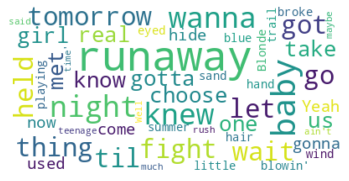

In [91]:
# lower max_font_size, change the maximum number of word and lighten the background:
from wordcloud import WordCloud

text = clean_text

wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Train a LDA model to extract potential topics

In [180]:
vectorizer = CountVectorizer()

data_vectorized = vectorizer.fit_transform(df['clean_lyrics'])

lda_model = LatentDirichletAllocation(n_components=4)

lda_vectors = lda_model.fit_transform(data_vectorized)

#### Visualize topics

In [181]:
def print_topics(model, vectorizer):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-10 - 1:-1]])

In [182]:
print_topics(lda_model, vectorizer)

Topic 0:
[('the', 4569.056664699092), ('you', 3369.472754576917), ('it', 2980.095494898713), ('and', 2758.5459930514553), ('to', 2160.4482254073514), ('in', 1637.016182808378), ('my', 1455.5628702917093), ('of', 1228.198657072106), ('that', 1156.436828002787), ('me', 1015.8797924569207)]
Topic 1:
[('you', 9670.415750019116), ('me', 3436.9225079076455), ('the', 3290.4114988701904), ('to', 3062.1677591198845), ('and', 2879.271025201305), ('my', 2494.6499185749212), ('love', 2244.192075393732), ('it', 2041.2430930109113), ('your', 2001.0462025215468), ('that', 1831.4311088255463)]
Topic 2:
[('the', 4943.59832310116), ('and', 1724.6048824251654), ('to', 1481.1896307951527), ('in', 1312.2329895085177), ('on', 1134.5740477660574), ('my', 1120.5272678741367), ('you', 850.865771681294), ('it', 849.9213048952804), ('that', 771.834110570785), ('of', 736.3097057230913)]
Topic 3:
[('the', 3764.9335133294826), ('to', 2608.194384677519), ('and', 2198.578099321991), ('you', 1392.245723722591), ('we',